## Example 2: Synaptic Response

Mechanisms found:  True
Mechanisms already loaded from path: mod/.  Aborting.


Running step trial 1... run 1 of 4 total iterations
Initiating HL23MN1 population...
Initiating HL23PN1 population...
Connected population HL23MN1 to HL23MN1 by 0 connections and 0 synapses
Connected population HL23MN1 to HL23PN1 by 1 connections and 12 synapses
Connected population HL23PN1 to HL23MN1 by 0 connections and 0 synapses
Connected population HL23PN1 to HL23PN1 by 0 connections and 0 synapses
Stimulating HL23MN1...
t = 100.0 ms
t = 200.0 ms
t = 300.0 ms
t = 400.0 ms
t = 500.0 ms
t = 600.0 ms
t = 700.0 ms


Running step trial 2... run 2 of 4 total iterations
Initiating HL23MN1 population...
Initiating HL23PN1 population...
Connected population HL23MN1 to HL23MN1 by 0 connections and 0 synapses
Connected population HL23MN1 to HL23PN1 by 1 connections and 12 synapses
Connected population HL23PN1 to HL23MN1 by 0 connections and 0 synapses
Connected population HL23PN1 to HL23PN1 by 0 connections and 0

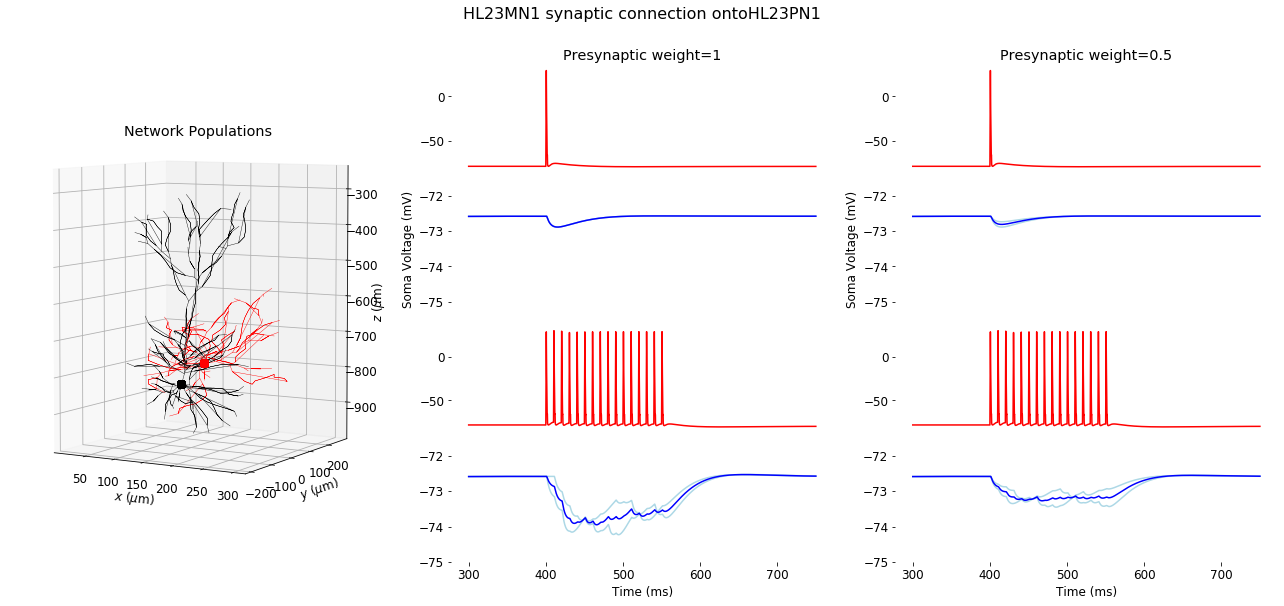

In [3]:
####################################################################
# Import Modules and load relevant files
####################################################################
import os
from os.path import join
import sys
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from matplotlib.collections import PolyCollection
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import scipy
from scipy import signal as ss
from scipy import stats as st
from mpi4py import MPI
import math
import neuron
from neuron import h, gui
import LFPy
from LFPy import NetworkCell, Network, Synapse, RecExtElectrode, StimIntElectrode
from net_params import *

print('Mechanisms found: ', os.path.isfile('mod/x86_64/special'))
neuron.h('forall delete_section()')
neuron.load_mechanisms('mod/')
h.load_file('net_functions.hoc')
h.load_file('models/biophys_HL23PN1.hoc')
h.load_file('models/biophys_HL23MN1.hoc')
h.load_file('models/biophys_HL23BN1.hoc')
h.load_file('models/biophys_HL23VN1.hoc')

####################################################################
# Simulation Controls
####################################################################

preN = 'HL23MN1'
postN = 'HL23PN1'

pre_syn_weight = .5

N_iterations_per_condition = 2

####################################################################
# Parameters and Output Storange
####################################################################
#somatic potentials
pre_somav_step = []
post_somav_step = []
pre_somav_train = []
post_somav_train = []

all_trials_somav_step = []
no_failures_somav_step = []

all_trials_somav_train = []
no_failures_somav_train = []

#synapse positions
post_synlist = []

preN_amp = 4.5
if preN=='HL23VN1':
    preN_amp = 15

postN_amp = 0
postN_dur = 0

#network variables

dt = 0.0625
tstart = 0.
tmid = 400. 
tstop = 750.
celsius = 34.
v_init = -80.

total_iterations = N_iterations_per_condition*2
step_delay = np.arange(tmid, 401, 1)
train_delay = np.arange(tmid, 560, 10)

original_cellnames = [preN, postN]
origninal_cellnames_copy = original_cellnames.copy()

L23_pop_args = {'radius':250,
                'loc':-800,
                'scale':500,
                'cap': float(200)}

rotations = {'HL23PN1':{'x':1.57,'y':2.62},
             'HL23MN1':{'x':1.77,'y':2.77},
             'HL23BN1':{'x':1.26,'y':2.57},
             'HL23VN1':{'x':-1.57,'y':3.57}}

networkParams = {
    'dt' : dt,
    'tstart': tstart,
    'tstop' : tstop,
    'v_init' : v_init,
    'celsius' : celsius,
    'verbose' : False,
    'OUTPUTPATH': 'Circuit_output'}

####################################################################
# Create Population Function
####################################################################
def generateSubPop(popsize,mname,popargs,Gou,Gtonic):
    print('Initiating ' + mname + ' population...')
    morphpath = 'morphologies/' + mname + '.swc'
    templatepath = 'models/NeuronTemplate.hoc'
    templatename = 'NeuronTemplate'

    cellParams = {
        'morphology': morphpath,
        'templatefile': templatepath,
        'templatename': templatename,
        'templateargs': morphpath,
        'v_init': v_init,
        'passive': False,
        'dt': dt,
        'tstart': 0.,
        'tstop': tstop,#defaults to 100
        'nsegs_method': None,
        'pt3d': False,
        'delete_sections': False,
        'verbose': False}

    rotation = rotations.get(mname)

    popParams = {
        'CWD': None,
        'CELLPATH': None,
        'Cell' : LFPy.NetworkCell,
        'POP_SIZE': popsize,
        'name': mname,
        'cell_args' : cellParams,
        'pop_args' : popargs,
        'rotation_args' : rotation}

    network.create_population(**popParams)
    # Add biophys, OU processes, & tonic inhibition to cells
    for cellind in range(0,len(network.populations[mname].cells)): #0 is redundant?
        biophys = 'h.biophys_' + mname + '(network.populations[\'' + mname + '\'].cells[' + str(cellind) + '].template)'
        exec(biophys)
        rseed = 1234
        h.createArtificialSyn(rseed,network.populations[mname].cells[cellind].template,Gou)
        h.addTonicInhibition(network.populations[mname].cells[cellind].template,Gtonic,Gtonic)
####################################################################
# Run Simulation
####################################################################
train_trial = 1
new_cellnames = ['to_be_filled', 'to_be_filled']
for run in range(total_iterations):
    networkParams = {
        'dt' : dt,
        'tstop' : tstop,
        'v_init' : v_init,
        'celsius' : 34,
        'OUTPUTPATH' : os.getcwd(),
        'verbose' : False
    }

# get rid of one of network params, 
    network = Network(**networkParams)

    #display run
    print('\n')
    print('Running step trial '+str(run+1)+'... run '+str(run+1)+' of '+str(total_iterations)+' total iterations') if run<N_iterations_per_condition else print('Running train trial '+str(run+1-N_iterations_per_condition)+'... Run '+str(run+1)+' of '+str(total_iterations)+' iterations')
    train_trial+=1

    ###################################
    # Generate Populations
    ###################################
    if original_cellnames[0]!=original_cellnames[1]:
        generateSubPop(1, preN, L23_pop_args,0,0)
        generateSubPop(1, postN, L23_pop_args,0,0)
        pre1=preN
        post2=postN

    
    if original_cellnames[0]==original_cellnames[1]:
        pre1 = origninal_cellnames_copy[0]
        post1 = origninal_cellnames_copy[1]

        #first generate pre3 and post4
        generateSubPop(1, pre1, L23_pop_args,0,0)
        pre3 = pre1[:-1]+str(3)
        network.populations[pre3] = network.populations[pre1]
        del network.populations[pre1]

        generateSubPop(1, post1, L23_pop_args,0,0)
        post4 = post1[:-1]+str(4)
        network.populations[post4] = network.populations[post1]
        del network.populations[post1]

        #then rename to pre1, post2
        pre1 = pre3[:-1]+str(1)
        network.populations[pre1] = network.populations[pre3]
        del network.populations[pre3]

        post2 = post4[:-1]+str(2)
        network.populations[post2] = network.populations[post4]
        del network.populations[post4]

    new_cellnames[0]=pre1
    new_cellnames[1]=post2

    population_sizes = []
    for pop in network.populations.values():
        population_sizes.append(pop.POP_SIZE)

    ###################################
    # Connectivity Parameters
    ###################################
    connectionProbability = np.array([[0, 1],[0, 0]]) #only Pre->Post connection

    E_syn = neuron.h.ProbAMPANMDA
    I_syn = neuron.h.ProbUDFsyn
    
    weightFunction = np.random.normal
    
    WP = {'loc':1, 'scale':0.0000001}
    pre_WP = {'loc':pre_syn_weight, 'scale':0.0000001}

    delayFunction = np.random.normal
    delayParams = {'loc':.5, 'scale':0.0000001}
    mindelay = 0.5
    
    multapseFunction = np.random.normal

    prec = new_cellnames[0]
    postc = new_cellnames[1]

    synapseParameters = [[syn_params['none'],syn_params[prec+postc]],[syn_params['none'],syn_params['none']]]
    weightArguments = [[WP, pre_WP], [WP, WP]]
    minweight = [[1, pre_syn_weight], [1, 1]]
    delayArguments = [[delayParams, delayParams], [delayParams, delayParams]]
    multapseArguments = [[mult_syns['none'],mult_syns[prec+postc]],[mult_syns['none'], mult_syns['none']]]
    synapsePositionArguments = [[pos_args['none'],pos_args[prec+postc]],[pos_args['none'],pos_args['none']]]
    
    ###################################
    # Connect Cells
    ###################################

    for i, prec in enumerate(new_cellnames):
        for j, postc in enumerate(new_cellnames):
            connectivity = network.get_connectivity_rand(pre=prec,post=postc,connprob=connectionProbability[i][j])

            (conncount, syncount) = network.connect(
                pre=prec, post=postc,
                connectivity=connectivity,
                syntype=E_syn if prec=='HL23PN1' else I_syn,
                synparams=synapseParameters[i][j],
                weightfun=weightFunction,
                weightargs=weightArguments[i][j],
                minweight=minweight[i][j],
                delayfun=delayFunction,
                delayargs=delayArguments[i][j],
                mindelay=mindelay,
                multapsefun=multapseFunction,
                multapseargs=multapseArguments[i][j],
                syn_pos_args=synapsePositionArguments[i][j])

    ###################################
    # Set Stimulation Parameters
    ###################################
    # step first, then train
    for name, pop in network.populations.items():
        if name==new_cellnames[0]:
            for cell in pop.cells:
                delays = step_delay if run<N_iterations_per_condition else train_delay
                pointprocesses = []
                pre_stimuli = []
                for i in range(len(delays)):
                    pointprocesses.append({
                        'idx' : 0,
                        'record_current' : True,
                        'pptype' : 'IClamp',
                        'amp' : preN_amp,
                        'dur' : 2,
                        'delay': delays[i]})
                for pointprocess in pointprocesses:
                    pre_stimuli.append(LFPy.StimIntElectrode(cell, **pointprocess))
        if name==new_cellnames[1]:
            for cell in pop.cells:
                pointprocess = {
                    'idx' : 0,
                    'record_current' : True,
                    'pptype' : 'IClamp',
                    'amp' : postN_amp,
                    'dur' : postN_dur,
                    'delay': tmid}
                post_stimuli = LFPy.StimIntElectrode(cell, **pointprocess)

    ###################################
    # Simulate
    ###################################
    simargs = {'electrode': None,
               'rec_imem': False,
               'rec_vmem': False,
               'rec_ipas': False,
               'rec_icap': False,
               'rec_isyn': False,
               'rec_vmemsyn': False,
               'rec_istim': False}

    print('Stimulating '+str(new_cellnames[0])+'...')
    SPIKES = network.simulate(**simargs)
    
    ###################################
    # Save somatic potentials across trials
    ###################################

    for name, pop in network.populations.items():
        if name==new_cellnames[0]:
            for cell in pop.cells:
                pre_somav_step.append(cell.somav) if run<N_iterations_per_condition else pre_somav_train.append(cell.somav)
        if name==new_cellnames[1]:
            for cell in pop.cells:
                post_somav_step.append(cell.somav) if run<N_iterations_per_condition else post_somav_train.append(cell.somav)
                post_synlist.append(cell.synidx)
    
    if run < total_iterations-1:
        network.pc.gid_clear()
        electrode = None
        syn = None
        synapseModel = None
        for population in network.populations.values():
            for cell in population.cells:
                cell = None
                population.cells = None
            population = None
            pop = None
            network = None
            neuron.h('forall delete_section()')
print('\n'+'Simulation complete ... plotting output ...')

####################################################################
# Plotting
####################################################################

startslice = 300
endslice = 750

t1 = int(startslice/network.dt)
t2 = int(endslice/network.dt)

conditions = ['step', 'train']

for i in conditions:
    exec('pre_somav_m_%s = np.mean(pre_somav_%s, axis=0)'%(i, i))
    exec('post_somav_m_%s = np.mean(post_somav_%s, axis=0)'%(i, i))
    if not os.path.isfile('Circuit_output/pre_sv_%s_1'%i) and pre_syn_weight==1:
        exec("np.save('Circuit_output/pre_sv_%s_1', pre_somav_%s)"%(i, i))
        exec("np.save('Circuit_output/post_sv_%s_1', post_somav_%s)"%(i, i))

font = {'family' : 'DejaVu Sans',
        'size'   : 12}
matplotlib.rc('font', **font)
fig = plt.figure(figsize=[18, 8])
tvec = np.arange(network.tstop / network.dt + 1) * network.dt

###################################
# Population Morphology
###################################

ax = plt.subplot2grid((4,3), (0,0), rowspan=4, colspan=1, projection='3d')
ax.view_init(elev=5)

popcolors = {
    'HL23PN1':'k',
    'HL23PN2':'k',
    'HL23MN1':'red',
    'HL23MN2':'red',
    'HL23BN1':'yellow',
    'HL23BN2':'yellow',
    'HL23VN1':'green',
    'HL23VN1':'green',
    'HL23VN2':'green'}

for i, pop in enumerate(network.populations):
    for cell in network.populations[pop].cells:
        for sec in neuron.h.allsec():
            idx = cell.get_idx(sec.name())
            ax.plot(np.r_[cell.xstart[idx], cell.xend[idx]],
                    np.r_[cell.ystart[idx], cell.yend[idx]],
                    np.r_[cell.zstart[idx], cell.zend[idx]], color=popcolors[pop], linewidth=0.4)
            ax.scatter(cell.somapos[0], cell.somapos[1], cell.somapos[2], c=popcolors[pop], marker='.', s=250)
        ax.set_xlabel('$x$ ($\mu$m)')
        ax.set_ylabel('$y$ ($\mu$m)')
        ax.set_zlabel('$z$ ($\mu$m)')
        ax.set_title('Network Populations')
        
###############################################
# Pre_syn_weight = 1
###############################################
yaxis = {'HL23PN1HL23PN1':[-73,-69.5],'HL23PN1HL23MN1':[-80,-68], 'HL23PN1HL23BN1':[-84, -74], 'HL23PN1HL23VN1':[-84, -73],
         'HL23MN1HL23PN1':[-75,-72],'HL23MN1HL23MN1':[-79,-78], 'HL23MN1HL23BN1':[-84, -74], 'HL23MN1HL23VN1':[-82.5, -81],
         'HL23BN1HL23PN1':[-76,-72],'HL23BN1HL23MN1':[-79,-78], 'HL23BN1HL23BN1':[-84, -82], 'HL23BN1HL23VN1':[-82.5, -81], 
         'HL23VN1HL23PN1':[-75,-72],'HL23VN1HL23MN1':[-79,-78], 'HL23VN1HL23BN1':[-84, -82], 'HL23VN1HL23VN1':[-82.5, -81], 
        }

    ###################################
    # Step Response
    ###################################
    
if os.path.isfile('Circuit_output/pre_sv_step_1.npy'):
    pre_sv_step_1 = np.load('Circuit_output/pre_sv_step_1.npy')
    post_sv_step_1 = np.load('Circuit_output/post_sv_step_1.npy')
    pre_somav_m_step_1 = np.mean(pre_sv_step_1, axis=0)
    post_somav_m_step_1 = np.mean(post_sv_step_1, axis=0)

    # Presynaptic Soma Voltage
    ax = plt.subplot2grid((4,3), (0,1), rowspan=1, colspan=1, frameon=False)
    for name, pop in network.populations.items():
        if name==new_cellnames[0]:
            for cell in pop.cells:
                ax.plot(tvec[t1:t2], pre_somav_m_step_1[t1:t2], c='red')
                ax.set_xticks([])
                title = 'Presynaptic weight=1'
                ax.set_title(title)

    # Postsynaptic Soma Voltage
    ax = plt.subplot2grid((4,3), (1,1), rowspan=1, colspan=1, frameon=False)
    for name, pop in network.populations.items():
        if name==new_cellnames[1]:
            for cell in pop.cells:
                for i in range(len(post_sv_step_1)):
                    plt.plot(tvec[t1:t2], np.array(post_sv_step_1)[i][t1:t2], c='lightblue')
                ax.plot(tvec[t1:t2], post_somav_m_step_1[t1:t2], c='blue')
                ax.set_xticks([])
                ax.set_ylabel('Soma Voltage (mV)')
                ax.set_ylim(yaxis[preN+postN])
                if postN!='HL23PN1' or postN!='HL23MN1':
                    ax.set_ylim()

    ###################################
    # Train Response
    ###################################
    pre_sv_train_1 = np.load('Circuit_output/pre_sv_train_1.npy')
    post_sv_train_1 = np.load('Circuit_output/post_sv_train_1.npy')
    pre_somav_m_train_1 = np.mean(pre_sv_train_1, axis=0)
    post_somav_m_train_1 = np.mean(post_sv_train_1, axis=0)

    # Presynaptic Soma Voltage
    ax = plt.subplot2grid((4,3), (2,1), rowspan=1, colspan=1, frameon=False)
    for name, pop in network.populations.items():
        if name==new_cellnames[0]:
            for x, cell in enumerate(pop.cells):
                if x==0:
                    ax.plot(tvec[t1:t2], pre_somav_m_train_1[t1:t2], c='red')
                    ax.set_xticks([])

    # Postsynaptic Soma Voltage
    ax = plt.subplot2grid((4,3), (3,1), rowspan=1, colspan=1, frameon=False)
    for name, pop in network.populations.items():
        if name==new_cellnames[1]:
            for x, cell in enumerate(pop.cells):
                for i in range(len(post_sv_train_1)):
                    plt.plot(tvec[t1:t2], np.array(post_sv_train_1)[i][t1:t2], c='lightblue')
                ax.plot(tvec[t1:t2], post_somav_m_train_1[t1:t2], c='blue')
                ax.set_xlabel('Time (ms)')
                ax.set_ylim(yaxis[preN+postN])
                if preN+postN=='HL23PN1HL23MN1':
                    ax.set_ylim([-80, 30])


suptitle = new_cellnames[0]+' synaptic connection onto ' +new_cellnames[1]
plt.suptitle(suptitle, y=1.05, fontsize=16)

if pre_syn_weight !=1:
    
    conditions = ['step', 'train']

    for i in conditions:
        exec('pre_somav_m_%s = np.mean(pre_somav_%s, axis=0)'%(i, i))
        exec('post_somav_m_%s = np.mean(post_somav_%s, axis=0)'%(i, i))
    
    ###############################################
    # Pre_syn_weight != 1
    ###############################################
    ###################################
    # Step Response
    ###################################
    # Presynaptic Soma Voltage
    ax = plt.subplot2grid((4,3), (0,2), rowspan=1, colspan=1, frameon=False)
    for name, pop in network.populations.items():
        if name==new_cellnames[0]:
            for cell in pop.cells:
                ax.plot(tvec[t1:t2], pre_somav_m_step[t1:t2], c='red')
                ax.set_xticks([])
                title = 'Presynaptic weight='+str(pre_syn_weight)
                ax.set_title(title)

    # Postsynaptic Soma Voltage
    ax = plt.subplot2grid((4,3), (1,2), rowspan=1, colspan=1, frameon=False)
    for name, pop in network.populations.items():
        if name==new_cellnames[1]:
            for cell in pop.cells:
                for i in range(len(post_somav_step)):
                    plt.plot(tvec[t1:t2], np.array(post_somav_step)[i][t1:t2], c='lightblue')
                ax.plot(tvec[t1:t2], post_somav_m_step[t1:t2], c='blue')
                ax.set_xticks([])
                ax.set_ylabel('Soma Voltage (mV)')
                ax.set_ylim(yaxis[preN+postN])
                if preN!='HL23PN1' or preN!='HL23MN1':
                    ax.set_ylim()

    ###################################
    # Train Response
    ###################################
    # Presynaptic Soma Voltage
    ax = plt.subplot2grid((4,3), (2,2), rowspan=1, colspan=1, frameon=False)
    for name, pop in network.populations.items():
        if name==new_cellnames[0]:
            for x, cell in enumerate(pop.cells):
                if x==0:
                    ax.plot(tvec[t1:t2], pre_somav_m_train[t1:t2], c='red')
                    ax.set_xticks([])

    # Postsynaptic Soma Voltage
    ax = plt.subplot2grid((4,3), (3,2), rowspan=1, colspan=1, frameon=False)
    for name, pop in network.populations.items():
        if name==new_cellnames[1]:
            for x, cell in enumerate(pop.cells):
                for i in range(len(post_somav_train)):
                    plt.plot(tvec[t1:t2], np.array(post_somav_train)[i][t1:t2], c='lightblue')
                ax.plot(tvec[t1:t2], post_somav_m_train[t1:t2], c='blue')
                ax.set_xlabel('Time (ms)')
                ax.set_ylim(yaxis[preN+postN])
                if preN+postN=='HL23PN1HL23MN1':
                    ax.set_ylim([-80, 30])


plt.tight_layout()
plt.show()
    
    
network.pc.gid_clear()
electrode = None
syn = None
synapseModel = None
for population in network.populations.values():
    for cell in population.cells:
        cell = None
        population.cells = None
    population = None
    pop = None
    network = None
    neuron.h('forall delete_section()')